In [1]:
import numpy as np
import pandas as pd
import math

from typing import Tuple
import src.hdmm.workload as workload
import src.census_workloads as census
from src.workload_selection import workload_selection
import online_workloads as online_workloads

In [2]:
def pmw_naive(workload, x, analyst_labels, T, eps=0.01, total_k=None, 
         show_messages=False, to_return='error', show_plot=False, show_failure_step=False, eta = None):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries where analysts can run out of privacy budget if they use too much of others'. 
    
    In other words, all analysts share from the same privacy budget. 
    
    Last Updated: 4-10-2022

    Algorithm Parameters: 
    - workload = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    - T = update threshold
    - eps = privacy budget
    - total_k = total number of update steps alloted for the entire group
    - analyst_labels = list of analyst names corresponding to each query in the workload
    
    Output Controls: 
    - show_messages argument determines whether the function will print information such as 
    error scale, threshold, update steps used, etc.
    - to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query in the workload(showing query, d_t_hat, updated, algo_ans, real_ans, 
        abs_error, rel_error). 
        - if 'update_count', pmw() returns the update count for the total
        amount of queries.
    - show_plot - T/F whether the function will display a plot
    - show_failure_step - T/F whether function prints what step failure mode is reached
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    if(eta == None):
        eta = (math.log(m, np.e) / ((math.sqrt(n))) )
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    
    # initialize synthetic databases at time 0 (prior to any queries)
    x_t = np.ones(m) / m
    y_t = np.ones(m) / m

    # initialize tracker lists to construct pandas dataframe at the end 
    x_list = [x_t] # create a list of x_t synthetic database at every time step
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = [] # record times that database is updated
    d_t_hat_list = []
    
    # initialize total_k, the total number of update steps if not default
    if total_k == None:
        total_k = round(n * math.log(math.sqrt(m)) / 770) #770
        #print(f'{total_k=}')
    
    def lazy_round():
        """
        "Lazy Round" of querying using the stored synthetic database, x_t, in list x_list.
        
        We call this the lazy round because it is contrasted with the updated step where we update the 
        sythetic database and answer the query using the real database.
        """
        update_list.append('no')
        answer = np.dot(query, x_list[time])
        if answer < 0:
            pmw_answers.append(0)
        else: 
            pmw_answers.append(answer)
        x_list.append(x_list[time])
    
    # inititate first instance of SVT with half the budget and k updates; will be reset in the main loop
    SVTtrigger = False 
    SVTepsilon1 = ((eps/2)/2)
    SVTepsilon2 = ((eps/2)/2)
    rho = np.random.laplace(loc=0, scale=(1/SVTepsilon1), size=1)[0]
    #print(rho + T)
    
    
    for time, query in enumerate(workload):
        
        analyst = analyst_labels[time]
        
        # Do one round of sparse vector technique; compute noisy answer by adding Laplacian noise
        A_t = np.random.laplace(loc=0, scale=(total_k/SVTepsilon2), size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + A_t
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        
        # LAZY ROUND: QUERY USING THE SYNTHETIC DATABASE
        if (abs(d_t_hat) <= T + rho):
            d_t_hat_list.append(d_t_hat)
            lazy_round()

        # UPDATE ROUND: UPDATE SYNTHETIC DATABASE AND RETURN NOISY ANSWER, A_T-HAT
        else:
            # noise
            A_t = np.random.laplace(loc=0, scale=(2*total_k/eps), size=1)[0]
            
            # noisy answer
            a_t_hat = (np.dot(query, x_norm)*n ) + A_t
            d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
            d_t_hat_list.append(d_t_hat)
            update_times.append(time)
            
            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i in range(len(y_t)):
                y_t[i] = x_list[time][i] * math.exp(-( eta * r_t[i]))# eta is the learning rate
            
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            # if threshold for num updates is reached, just do a lazy round (synthetic database) answer
            if total_k == 0: 
                if show_failure_step:
                    print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
                
            # if there are still update steps that the analyst can use, 
            # 1. update the synthetic database
            # 2. answer the query using the noisy answer from the database itself 
            else: 
                x_list.append(x_t)
                update_list.append('yes') # increment number of updates counter
                answer = a_t_hat / np.sum(x)
                
                if answer < 0:
                    pmw_answers.append(0)
                else: 
                    pmw_answers.append(answer)
                
                total_k -= 1 # use one of the total update steps
        
        #print(f'{x_list[time] - x_list[time - 1]=}')
        
        
    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    if show_messages:
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Synthetic Database (after) = {x_list[len(x_list) - 1] * sum(x)}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Synthetic Database (before) = {x_list[0]}\n')
        print(f'Synthetic Database (after, norm) = {x_list[len(x_list) - 1]}\n')
        print(f'Difference btw. Final Synthetic and true database = {x_list[len(x_list) - 1] - x_norm}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{T=}\n')
        print(f'Error Scale Query Answer= {2*((2*total_k/eps)**2)}\n')
        print(f'Error Scale SVT= {2*((2*total_k/SVTepsilon2)**2)}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
        
    if show_plot: 
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[abs_line,rel_line])
        plt.xticks(range(0, len(workload), round(len(workload)/5)))
    
    if to_return == "pd":
        # hacky fix: remove the first synthetic database to keep length of lists consistent with the
        # other lists that comprise of the pandas dataframe
        x_list.pop(0).tolist() 
        d = {
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'queries': workload.tolist(), 
            'updated': update_list,
            'abs_error': abs_error,               
            'rel_error': rel_error,
            'synthetic database': x_list,
            'analyst': analyst_labels,
            'd_t_hat': d_t_hat_list, 

             }
        test_data = pd.DataFrame(data=d)
        #test_data = test_data.round(3)
        return test_data
    
    if to_return == "error":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,               
             'rel_error': rel_error,}
        data = pd.DataFrame(data=d)
        data = data.round(3)
        
        analyst_error = {}
        for analyst in list(sorted(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error
    
    if to_return == "tse":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,}
        data = pd.DataFrame(data=d)
        data['squared_err'] = data['abs_error'] ** 2
        
        analyst_error = {}
        for analyst in list(sorted(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error

In [3]:
import matplotlib.pyplot as plt

def plot_databases(data, y_upper=0.05):
    """
    Plot True and Synthetic database side by side
    
    Input: 
    - data = pd.DataFrame returned from pmw()
    - y_upper = y upperbound on the plot
    """
    y_upper = 0.05

    x1 = range(64)
    y1 = x_race[:64] / sum(x_race[:64])

    final_synthdb = data.iloc[len(data) - 1, 6]
    x2 = range(64)
    y2 = final_synthdb

    plt.subplot(1, 2, 1)
    plt.plot(x1, y1, color ="red")
    plt.ylim([0, y_upper])
    plt.title('True Database')

    plt.subplot(1, 2, 2)
    plt.plot(x2, y2, color ="red")
    plt.title('A tale of 2 subplots')
    plt.ylim([0, y_upper])
    plt.title('Final Synthetic Database')


    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()


In [4]:
n=64
ten_identity_q = np.vstack((online_workloads.identity(n), 
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n)))

large_w = np.vstack((ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q))

print(f'{large_w.shape=}')

large_w.shape=(6400, 64)


In [5]:
data_path = "migration_tworace.csv"
x_race = pd.read_csv(data_path, header=None).to_numpy().T[1][:64] # truncate to first 64
x_race

array([412, 333, 285, 231, 202, 174, 160, 142, 146, 149, 145, 181, 174,
       190, 213, 287, 372, 499, 619, 715, 785, 821, 822, 816, 799, 742,
       717, 697, 658, 593, 564, 519, 447, 403, 388, 365, 336, 306, 311,
       289, 261, 231, 213, 196, 194, 170, 175, 168, 149, 142, 131, 119,
       112, 118, 114, 116, 112, 114, 106, 111, 109, 112, 113, 109])

In [6]:
n=64
W_name = ['identity', 'total', 'H2', 'race1', 'race2', 'race3', 'custom', 'prefix_sum']
W_lst = [online_workloads.identity(n), online_workloads.total(n), online_workloads.H2(n), online_workloads.race1(), online_workloads.race2(), online_workloads.race3(), online_workloads.custom(n), online_workloads.prefix_sum(n)]

c = np.random.randint(len(W_lst))
final_W = W_lst[c] 

data_test = pmw_naive(workload = large_w, 
                          x = x_race[:64], 
                          analyst_labels = ['A'] * len(large_w), 
                          eps=1, 
                          T=40, 
                          total_k = 1000, 
                          show_messages=True, to_return='pd')
data_test

Original database: [412 333 285 231 202 174 160 142 146 149 145 181 174 190 213 287 372 499
 619 715 785 821 822 816 799 742 717 697 658 593 564 519 447 403 388 365
 336 306 311 289 261 231 213 196 194 170 175 168 149 142 131 119 112 118
 114 116 112 114 106 111 109 112 113 109]

Synthetic Database (after) = [349.92291984 381.78184115 293.95891292 254.2231927  330.17470914
 277.36908064 330.17470914 277.36908064 269.42863708 302.62229846
 285.54354033 320.72256098 285.54354033 311.54100625 302.62229846
 320.72256098 302.62229846 370.85229862 404.61674653 381.78184115
 393.03349279 416.54137517 381.78184115 428.81743951 381.78184115
 370.85229862 404.61674653 428.81743951 360.23564394 393.03349279
 360.23564394 360.23564394 404.61674653 302.62229846 360.23564394
 381.78184115 360.23564394 330.17470914 311.54100625 269.42863708
 293.95891292 285.54354033 339.90542549 302.62229846 269.42863708
 311.54100625 311.54100625 320.72256098 254.2231927  277.36908064
 233.00878222 277.36908064 269

,algo_ans,real_ans,queries,updated,abs_error,rel_error,synthetic database,analyst,d_t_hat
0,0.077526,0.020096,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.057431,2.857877,"[0.016078087069513525, 0.015617808141753755, 0...",A,1269.101451
1,0.080665,0.016242,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.064423,3.966367,"[0.016070690069519965, 0.016070690069519965, 0...",A,1333.603923
2,0.000000,0.013901,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.013901,1.000000,"[0.016077875215613727, 0.016077875215613727, 0...",A,-4639.868416
3,0.000000,0.011267,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.011267,1.000000,"[0.016085066789485812, 0.016085066789485812, 0...",A,-1175.000139
4,0.064163,0.009853,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.054311,5.512262,"[0.016077663367296862, 0.016077663367296862, 0...",A,995.141562
...,...,...,...,...,...,...,...,...,...
6395,0.012765,0.005414,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,0.007351,1.357797,"[0.01706774557813242, 0.018621687696525512, 0....",A,-150.715510
6396,0.012400,0.005317,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,0.007083,1.332323,"[0.01706774557813242, 0.018621687696525512, 0....",A,-145.223193
6397,0.012765,0.005463,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,0.007302,1.336746,"[0.01706774557813242, 0.018621687696525512, 0....",A,-149.715510
6398,0.013142,0.005512,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,0.007630,1.384324,"[0.01706774557813242, 0.018621687696525512, 0....",A,-156.428637


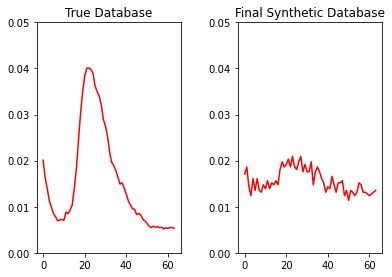

In [7]:
plot_databases(data_test)

# Scheduler

In [8]:
def skewed_scheduler(a: np.ndarray, b: np.ndarray, p: int) -> Tuple: 
    """
    Schedules Alice's queries with a probability of p and Bob's queries with a probability of (p - 1).
    
    Returns new workload of queries (2x2 np.array) and analyst labels (python list). 
    
    p: prob of scheduling Alice's queries
    a: alice's workload
    b: bob's workload
    """
    
    W = []
    analyst_labels = []
    
    if a.shape[1] != b.shape[1]:
         raise TypeError("a and b dimensions don't match")
    
    a_pointer = 0
    b_pointer = 0
    
    while(a_pointer < len(a) and b_pointer < len(b)):
        if np.random.random() < p:
            W.append(a[a_pointer])
            a_pointer += 1
            analyst_labels.append('A')
        else: 
            W.append(b[b_pointer])
            b_pointer += 1
            analyst_labels.append('B')
    
    if a_pointer == len(a):
        W = np.vstack((W, b[b_pointer:]))
        analyst_labels += ['B' for i in range(b_pointer, len(b))]
    if b_pointer == len(b): 
        W = np.vstack((W, a[a_pointer:]))
        analyst_labels += ['A' for i in range(a_pointer, len(a))]
    
    W = np.array(W)
    return W, analyst_labels

a_ex = np.array([[1, 2, 3],
             [4, 5, 6],
             [7, 8, 9]])

b_ex = np.array([[11, 22, 33],
             [44, 55, 66],
             [77, 88, 99]])
    
skewed_scheduler(a_ex, b_ex, 0.5)

(array([[ 1,  2,  3],
        [11, 22, 33],
        [44, 55, 66],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [77, 88, 99]]),
 ['A', 'B', 'B', 'A', 'A', 'B'])

In [9]:
skewed_scheduler(a_ex, b_ex, 1)

(array([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [11, 22, 33],
        [44, 55, 66],
        [77, 88, 99]]),
 ['A', 'A', 'A', 'B', 'B', 'B'])

In [10]:
skewed_scheduler(a_ex, b_ex, 0.9)

(array([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [11, 22, 33],
        [44, 55, 66],
        [77, 88, 99]]),
 ['A', 'A', 'A', 'B', 'B', 'B'])

In [11]:
skewed_scheduler(a_ex, b_ex, 0.8)

(array([[11, 22, 33],
        [ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [44, 55, 66],
        [77, 88, 99]]),
 ['B', 'A', 'A', 'A', 'B', 'B'])

In [12]:
skewed_scheduler(a_ex, b_ex, 0.7)

(array([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [11, 22, 33],
        [44, 55, 66],
        [77, 88, 99]]),
 ['A', 'A', 'A', 'B', 'B', 'B'])

In [13]:
skewed_scheduler(a_ex, b_ex, 0.6)

(array([[11, 22, 33],
        [ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [44, 55, 66],
        [77, 88, 99]]),
 ['B', 'A', 'A', 'A', 'B', 'B'])

In [14]:
skewed_scheduler(a_ex, b_ex, 0.5)

(array([[11, 22, 33],
        [ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [44, 55, 66],
        [77, 88, 99]]),
 ['B', 'A', 'A', 'A', 'B', 'B'])

# Motivating Experiment

In [15]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [16]:
# initialize workloads
W_lst = [online_workloads.identity(n), online_workloads.total(n), online_workloads.custom(n), online_workloads.prefix_sum(n)] #online_workloads.race1(), online_workloads.race2(), online_workloads.race3(),
W_name = ['identity', 'total', 'H2', 'custom', 'prefix_sum'] #, 'race1', 'race2', 'race3'

def motivating_exp(p, t):
    diff_lst=[]
    for i in range(t):
        # generate two identical workloads
        c = np.random.randint(len(W_lst))

        alice = W_lst[c]
        bob = W_lst[c]
        # skewed scheduler
        W, analyst_labels = skewed_scheduler(alice, bob, p)

        # PMW calculate error
        error_dict = pmw_naive(W, x_race, analyst_labels, eps=1, T=40, to_return='error')

        # subtract errors to get difference
        diff = error_dict['A'] - error_dict['B']
        # append difference to list for this specific p
        diff_lst.append(diff)

    return diff_lst

In [26]:
diff_pointfive = motivating_exp(0.5, t=100)

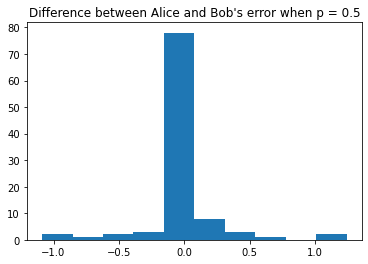

Mean = 0.0009399999999999653


In [41]:
plt.hist(diff_pointfive)
plt.title("Difference between Alice and Bob's error when p = 0.5")
plt.show()
print(f'Mean = {sum(diff_pointfive) / len(diff_pointfive)}')

In [28]:
diff_pointsevenfive = motivating_exp(0.75, t=100)

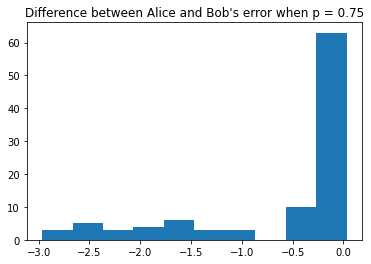

Mean = -0.5941300000000002


In [39]:
plt.hist(diff_pointsevenfive)
plt.title("Difference between Alice and Bob's error when p = 0.75")
plt.show()
print(f'Mean = {sum(diff_pointsevenfive) / len(diff_pointsevenfive)}')

In [30]:
diff_one = motivating_exp(1, t=100)

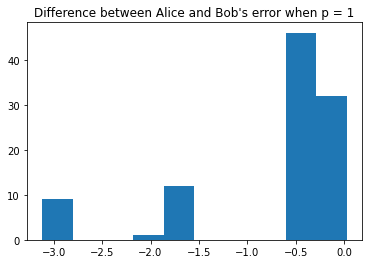

Mean = -0.6710899999999999


In [40]:
plt.hist(diff_one)
plt.title("Difference between Alice and Bob's error when p = 1")
plt.show()
print(f'Mean = {sum(diff_one) / len(diff_one)}')

This seems to be accurate. As p increases, Alice gets to answer more of her queries earlier, resulting in her having less and less error compared to Bob. 

As you can see, 

- in the p=0.5 setting, she has 0.0009399999999999653 less error than Bob
- in the p=0.75 setting, she has 0.594 less error than Bob
- in the p=1 setting, she has 0.67 less error than Bob. 

# Workload Constructor (WIP)

In [20]:
# WIP: 4-12-2022

import string
alphabet = list(string.ascii_lowercase)
alphabet

W_lst = [online_workloads.identity(n), online_workloads.total(n), online_workloads.race1(), online_workloads.race2(), online_workloads.race3(), online_workloads.custom(n), online_workloads.prefix_sum(n)]


W_lst = [online_workloads.identity(n)]
W_name = ['identity']

def workload_selection(W_lst, W_name, k, analyst_names=None):
    """
    Create a workload
    
    W_lst = Workload list
    W_name = Workload name
    k = number of analysts
    analyst_names = Analyst names, default = lowercase alphabet letters (i.e. analysts 'a', 'b', etc.)
    """
    
    if analyst_names == None:
        #if analyst_names: 
        #    raise TypeError("a and b dimensions don't match")
        #else: 
        analyst_names = alphabet[:k]
    
    Wn = []
    analyst_labels = []
    
    c = np.random.randint(len(W_lst))
    Ws = W_lst[c]
    Wn.append(W_name[c])
    
    #for i in range(len(analyst_names) - 1):
    #    c = np.random.randint(len(W_lst))
    #    Ws = Ws.vstack(Ws, W_lst[c])
    #    Wn.append(W_name[c])
    return Ws, Wn, analyst_labels

workload_selection(W_lst, W_name, 2)


# other WIP attemps: 


n=64
W_name = ['identity', 'total', 'H2', 'race1', 'race2', 'race3', 'custom', 'prefix_sum']
W_lst = [online_workloads.identity(n), online_workloads.total(n), online_workloads.H2(n), online_workloads.race1(), online_workloads.race2(), online_workloads.race3(), online_workloads.custom(n), online_workloads.prefix_sum(n)]

c = np.random.randint(len(W_lst))
final_W = W_lst[c] 

t = 10
for i in range(t): 
    c = np.random.randint(len(W_lst))
    print(c)
    final_W = np.vstack((final_W, W_lst[c]))
    
print(len(final_W))

final_W



5
3
4
2
6
0
6
1
4
3
509


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 1., 1.]])

In [21]:
# initialize databases

import pandas as pd
data_path = "migration_tworace.csv"
#x_race = pd.read_csv(data_path, header=None).iloc[:, 1].to_numpy()
n = x_race.shape[0]
x_race

x_example = np.array([1000, 2000, 3000, 4000, 5000])
new_x = np.array([.1, .15, .2, .25, .3]) * 1500

In [22]:
x_race_first_ten = x_race[:10]

# try identity on the race database
data = pmw_naive(hundred_identity_q, x_race_first_ten, ['A'] * 1000, eps=10, T=40, total_k = 100, 
          show_messages=True, to_return = 'pd')#to_return='tse')
data
data['abs_error'].sum() / len(data)

NameError: name 'hundred_identity_q' is not defined